# **2020 하계 프로젝트 #2**

* Eveing 스터디 2020년 하계 방학 개인 프로젝트 # 2
* 개발기간 : 2020.08.07~
* 주제 : 4 African animals dataset을 이용한 기초 GAN 연습

## **settings**

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# 환경설정
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import datasets
from torch.autograd import Variable
from torchvision.utils import save_image

In [ ]:
from PIL import Image
import glob
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

## **data**

In [ ]:
np.random.seed(0)
 
data_dir = '/content/gdrive/My Drive/Colab Notebooks/gan_project/data/Animal/'

In [ ]:
import torchvision.datasets as dset
from torchvision.datasets import ImageFolder

# imageSize = (64, 64)
data_transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

dataset = ImageFolder(data_dir, transform = data_transform)

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 32
test_split = .5
shuffle_dataset = True
random_seed= 42

# 커스텀 이미지를 train test 로 split
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=test_sampler, num_workers=4)


In [ ]:
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1) # ??

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


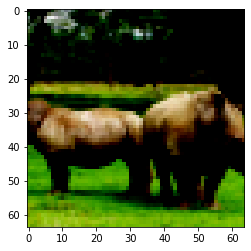

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


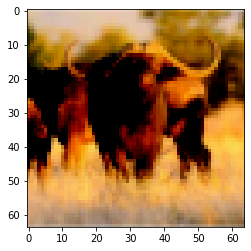

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


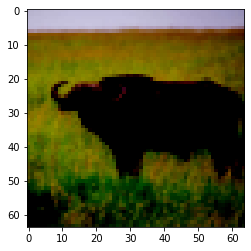

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


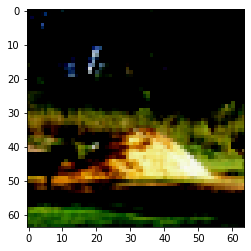

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


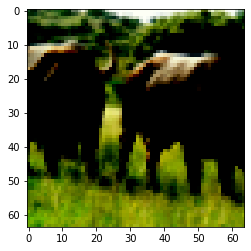

In [ ]:
for i in range(5):
    plt.imshow(imgs[i])
    plt.show()

In [ ]:
import torch.nn as nn

nz = 100 # 노이즈 벡터의 크기
nc = 3 # 채널의 수
niter = 200 # 에폭 수
lr = 0.0002
beta1 = 0.5

imageSize = 64 # 만들어지는 이미지의 크기
batchSize = 64 # 미니배치의 크기
outf = "result"

## **Weights**

weigth의 초기값을 설정해준다. Convloution layer의 경우 평균이 0, 표준편차가 0.02인 정규분포에서, Batch normalization의 경우 평균은 1.0 표준편차는 0.02인 layer에서 값을 뽑아낸다.

In [ ]:
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

## **Generator**

In [ ]:
# 생성자는 (batchSize x 100) 크기의 랜덤 벡터 ‘z’를 입력으로 받아 
# 가짜 이미지를 (batchSize x 3 x 28 x 28) 크기로 출력한다.
class Generator (nn.Module):
  def __init__(self):
    super(Generator, self).__init__()    

    self.main = nn.Sequential(
        nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False), #  batch norm을 가지는 경우, convolution의 bias가 의미를 잃게 된다고 함
        nn.BatchNorm2d(512),
        nn.ReLU(True),

        nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),

        nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),

        nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),

        nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )
  def forward(self, input):
    output = self.main(input)
    return output

## **Discriminator**

In [ ]:
# 구분자는 이미지를 입력으로 받아 이미지가 진짜인지 가짜인지(0~1값으로) 출력한다.
class Discriminator (nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.main = nn.Sequential(
        # (fake or real image) input size = (3, 64, 64)
        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), # (3, 64, 64) -> (64, 32, 32)
        nn.LeakyReLU(0.2, inplace=True),  
        
        nn.Conv2d(64, 128, kernel_size=4, stride = 2, padding=1, bias=False), # (64, 32, 32) -> (128, 16, 16)  
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True),    

        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),   # (128, 16, 16) -> (256, 8, 8)
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True), 
  
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),   # (256, 8, 8) -> (512, 4, 4)
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace = True), 
        
        nn.Conv2d(512, 1,kernel_size=4, stride=1, padding=0, bias=False),
        nn.Sigmoid()
    )
  def forward(self, input):
    output = self.main(input)
    return output.view(-1, 1).squeeze(1)


In [ ]:
# 생성자 객체 생성
G = Generator()
G.apply(weights_init)
print(G)

# 판별자 객체 생성
D = Discriminator()
D.apply(weights_init)
print(D)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
G_par = sum(p.numel() for p in G.parameters() if p.requires_grad)
D_par = sum(p.numel() for p in D.parameters() if p.requires_grad)
print('생성자의 parameter 수:', G_par)
print('판별자의 parameter 수:', D_par)

생성자의 parameter 수: 3576704
판별자의 parameter 수: 2765568


* 판별자 출력 확인 : 
torch.Size([10])
tensor([0.8332, 0.3575, 0.1233, 0.7763, 0.5024, 0.5484, 0.2530, 0.6125, 0.6252,
        0.2967], grad_fn=<SqueezeBackward1>)

* 생성자 출력 확인 : 
torch.Size([64, 3, 64, 64])
tensor([ 2.6253e-02, -7.2187e-02, -5.7119e-03, -5.1474e-02,  9.4231e-02,
        -9.4665e-02,  1.1376e-02,  5.0769e-03,  8.4518e-02, -2.2673e-02,
         6.4822e-02, -7.9373e-02, -1.0181e-02, -9.7874e-02, -9.9606e-03,
        -3.3795e-02,  5.3497e-02, -5.8773e-02,  7.4517e-02, -1.1472e-01,
         9.6561e-02, -9.1014e-02,  3.0994e-02, -8.2574e-02,  8.5164e-02,
        -1.1145e-01,  8.1773e-02,  3.0434e-02, -5.9794e-02, -9.8451e-02,
        -3.0804e-02,  5.0736e-02,  2.0813e-02, -1.7343e-02,  5.8449e-02,
         2.2392e-02, -4.6715e-06, -1.1689e-01, -5.9530e-03, -1.0817e-02,
        -1.2525e-02,  4.5404e-02, -2.5570e-02, -6.5951e-02,  1.0435e-01,
        -1.1808e-01, -8.0413e-03,  6.6841e-02,  3.7237e-02,  1.3858e-02,
         1.1286e-01,  2.7796e-02, -1.5703e-02, -5.1078e-02, -2.9544e-

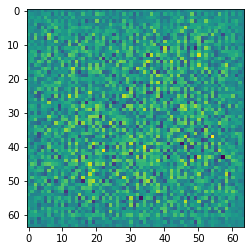

In [ ]:
# 판별자 테스트
test_input = (torch.rand(10, 3, 64, 64))
out = D(test_input)
print('* 판별자 출력 확인 : ')
print(out.shape)
print(out)
print()
# 생성자 테스트
test_z = (torch.rand(64, 100, 1, 1))
out2 = G(test_z)
print('* 생성자 출력 확인 : ')
print(out2.shape)
print(out2[0][0][0])
printable = out2.cpu().detach().numpy()
plt.imshow(printable[0][0])

## **Training**

In [ ]:
epochNum = 30
learning_rate = 0.001

In [ ]:
from torch.optim import Adam
# 생성자의 매개 변수를 최적화하는 Adam optimizer
optimizerG = Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
# 구분자의 매개 변수를 최적화하는 Adam optimizer
optimizerD = Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
# Binary Cross Entropy loss
# 진짜냐 가짜냐 두가지를 구분하는 것이므로
criterion = nn.BCELoss()

In [ ]:
import torchvision.utils as vutils
from torch.autograd import Variable

# 입력으로 사용할 벡터
input = torch.FloatTensor(batch_size, 3, imageSize, imageSize)

# 출력으로 사용할 벡터
noise = torch.FloatTensor(batch_size, 100, 1, 1)

# 학습 진행과정 확인을 위한 고정벡터
fixed_noise = torch.FloatTensor(batch_size, 100, 1, 1).normal_(0,1)
fixed_noise = Variable(fixed_noise)

label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

In [ ]:
for epoch in range(epochNum):
  for i, data in enumerate(train_loader):
    # 판별자를 dataset의 진짜 이미지로 학습시키기
    D.zero_grad()
    real, _ = data
    batch_size = real.size(0)

    input.resize_as_(real).copy_(real)
    label.resize_(batch_size).fill_(real_label)

    inputv = Variable(input)
    labelv = Variable(label)

    output = D(inputv)
    errD_real = criterion(output, labelv) # 진짜 판단 시 오류 계산
    errD_real.backward()
    D_x = output.data.mean()

    # 판별자를 생성자가 만든 가짜 이미지로 학습시키기
    noise.resize_(batch_size, 100, 1, 1).normal_(0,1)
    noisev = Variable(noise)
    fake = G(noisev)
    labelv = Variable(label.fill_(fake_label))
    output = D(fake.detach()) # .detach() : 계산 멈출때
    errD_fake = criterion(output, labelv) # 가짜 판단 시 오류 계산
    errD_fake.backward()
    D_G_z1 = output.data.mean()

    # total error 역전파
    errD = errD_real + errD_fake
    optimizerD.step()


    G.zero_grad()
    labelv = Variable(label.fill_(real_label))
    output = D(fake)
    errG = criterion(output, labelv) # 가짜이미지가 얼마나 진짜 같은지 그 격차를 줄이는게 목표
    errG.backward()
    D_G_z2 = output.data.mean()
    optimizerG.step()

    # loss 출력
    print(i, "step")
    fake = G(fixed_noise)
    print('[%d/%d][%d/%d] Loss_D: %.4f; Loss_G: %.4f' % (epoch, epochNum, i, len(train_loader), errD.item(), errG.item()))


0 step
[0/30][0/24] Loss_D: 0.7470; Loss_G: 6.5367
1 step
[0/30][1/24] Loss_D: 0.6113; Loss_G: 5.2794
2 step
[0/30][2/24] Loss_D: 0.9037; Loss_G: 6.3958
3 step
[0/30][3/24] Loss_D: 0.9457; Loss_G: 7.5385
4 step
[0/30][4/24] Loss_D: 1.1099; Loss_G: 6.0460
5 step
[0/30][5/24] Loss_D: 1.0781; Loss_G: 7.0722
6 step
[0/30][6/24] Loss_D: 1.0677; Loss_G: 7.9496
7 step
[0/30][7/24] Loss_D: 1.0094; Loss_G: 8.2199
8 step
[0/30][8/24] Loss_D: 0.4907; Loss_G: 9.5690
9 step
[0/30][9/24] Loss_D: 0.5256; Loss_G: 7.6198
10 step
[0/30][10/24] Loss_D: 0.7533; Loss_G: 10.7446
11 step
[0/30][11/24] Loss_D: 0.7008; Loss_G: 7.3357
12 step
[0/30][12/24] Loss_D: 0.7204; Loss_G: 11.4145
13 step
[0/30][13/24] Loss_D: 0.1529; Loss_G: 8.6428
14 step
[0/30][14/24] Loss_D: 0.8519; Loss_G: 9.4645
15 step
[0/30][15/24] Loss_D: 0.3728; Loss_G: 9.0899
16 step
[0/30][16/24] Loss_D: 0.7561; Loss_G: 9.9822
17 step
[0/30][17/24] Loss_D: 0.5904; Loss_G: 9.3174
18 step
[0/30][18/24] Loss_D: 0.5312; Loss_G: 9.6737
19 step
[0/

## **test**

* 판별자 출력 확인 : 
torch.Size([10])
tensor([3.6928e-05, 2.9618e-05, 1.0864e-05, 3.7533e-05, 5.0006e-05, 5.3244e-06,
        1.9020e-05, 2.2290e-05, 5.8177e-05, 1.9256e-05],
       grad_fn=<SqueezeBackward1>)

* 생성자 출력 확인 : 
torch.Size([64, 3, 64, 64])
tensor([0.4729, 0.5148, 0.4629, 0.5548, 0.5337, 0.5536, 0.5950, 0.6588, 0.6158,
        0.5899, 0.5717, 0.5810, 0.5656, 0.5855, 0.5794, 0.6312, 0.6124, 0.6290,
        0.6386, 0.6529, 0.6413, 0.6326, 0.6407, 0.6918, 0.6950, 0.6737, 0.6576,
        0.6478, 0.6325, 0.6530, 0.6487, 0.6935, 0.6555, 0.6662, 0.6418, 0.6573,
        0.6343, 0.6260, 0.6249, 0.7009, 0.6695, 0.6414, 0.6036, 0.5701, 0.5427,
        0.5444, 0.5087, 0.5293, 0.4187, 0.4410, 0.4173, 0.4444, 0.4004, 0.4234,
        0.4010, 0.5134, 0.4600, 0.4795, 0.4447, 0.4605, 0.4099, 0.4556, 0.3599,
        0.4136], grad_fn=<SelectBackward>)


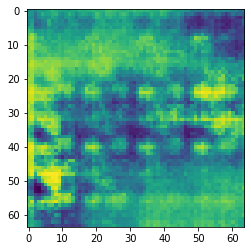

In [ ]:
# 판별자 테스트
test_input = (torch.rand(10, 3, 64, 64))
out = D(test_input)
print('* 판별자 출력 확인 : ')
print(out.shape)
print(out)
print()
# 생성자 테스트
test_z = (torch.rand(64, 100, 1, 1))
out2 = G(test_z)
out2 = (out2+1)/2 # 생성이미지의 범위[-1, 1] -> [0,1] 변환해주는 과정
print('* 생성자 출력 확인 : ')
print(out2.shape)
print(out2[0][0][0])
printable = out2.cpu().detach().numpy()
plt.imshow(printable[0][0])

epoch을 30만 돌린 것에 비하면 확실히 모델이 학습을 했다고 볼 수 있다. 에폭을 더 늘려서 향후 학습을 진행해야겠다. 